Comparative analysis of SiO2 datasets started...
✓ Successfully loaded all SiO2 datasets

SiO2Comparison of basic information of data sets

v=1 data set:
  - data shape: (6000, 16)
  - Wave number range: 0 - 5999 cm⁻¹
  - temperature column: 15
  - Temperature range: 100 - 1500 K
  - Numerical range: 2.27e-47 - 1.27e-17
  - average value: 6.07e-21

v=10 data set:
  - data shape: (601, 31)
  - Wave number range: 0 - 6000 cm⁻¹
  - temperature column: 30
  - Temperature range: 100 - 3000 K
  - Numerical range: 3.63e-45 - 1.71e-18
  - average value: 5.65e-21

v=20 data set:
  - data shape: (301, 21)
  - Wave number range: 0 - 6000 cm⁻¹
  - temperature column: 20
  - Temperature range: 100 - 2000 K
  - Numerical range: 6.98e-44 - 8.49e-19
  - average value: 5.95e-21

Data preprocessing

deal with v=1 data set...
  ✓ v=1: Training data 72000 行
    Test data 18000 行

deal with v=10 data set...
  ✓ v=10: Training data 16227 行
    Test data 1803 行

deal with v=20 data set...
  ✓ v=20: Training 

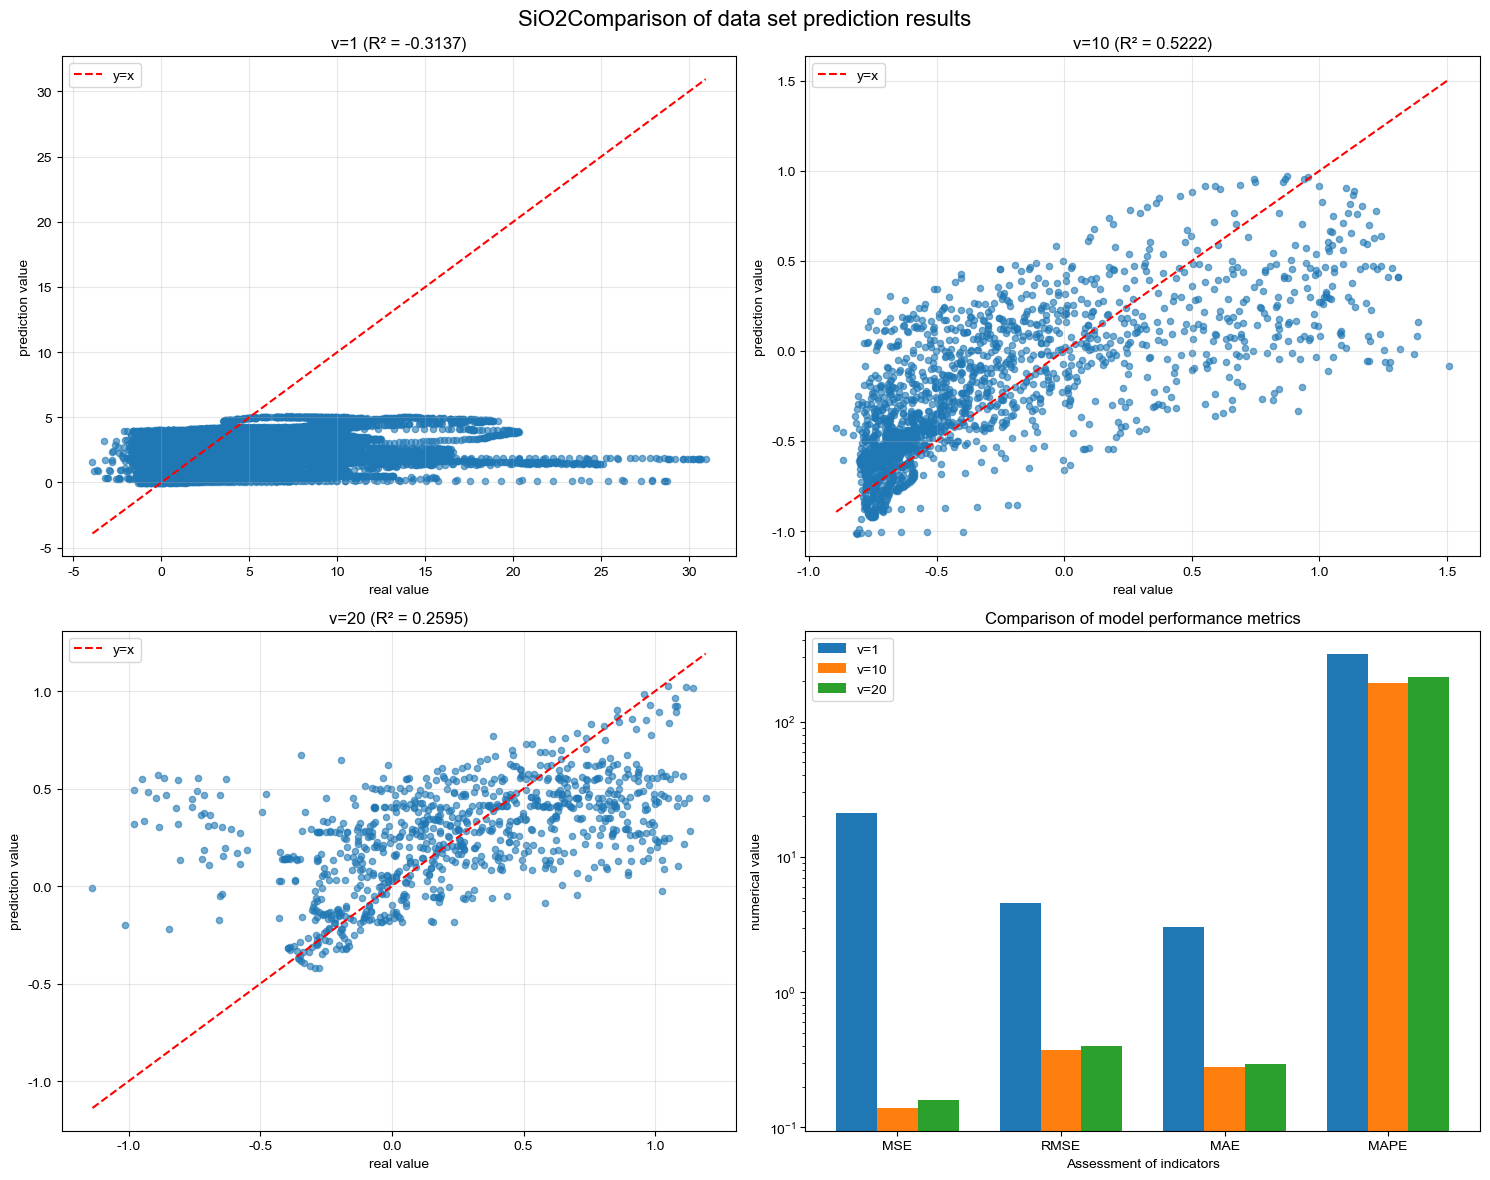

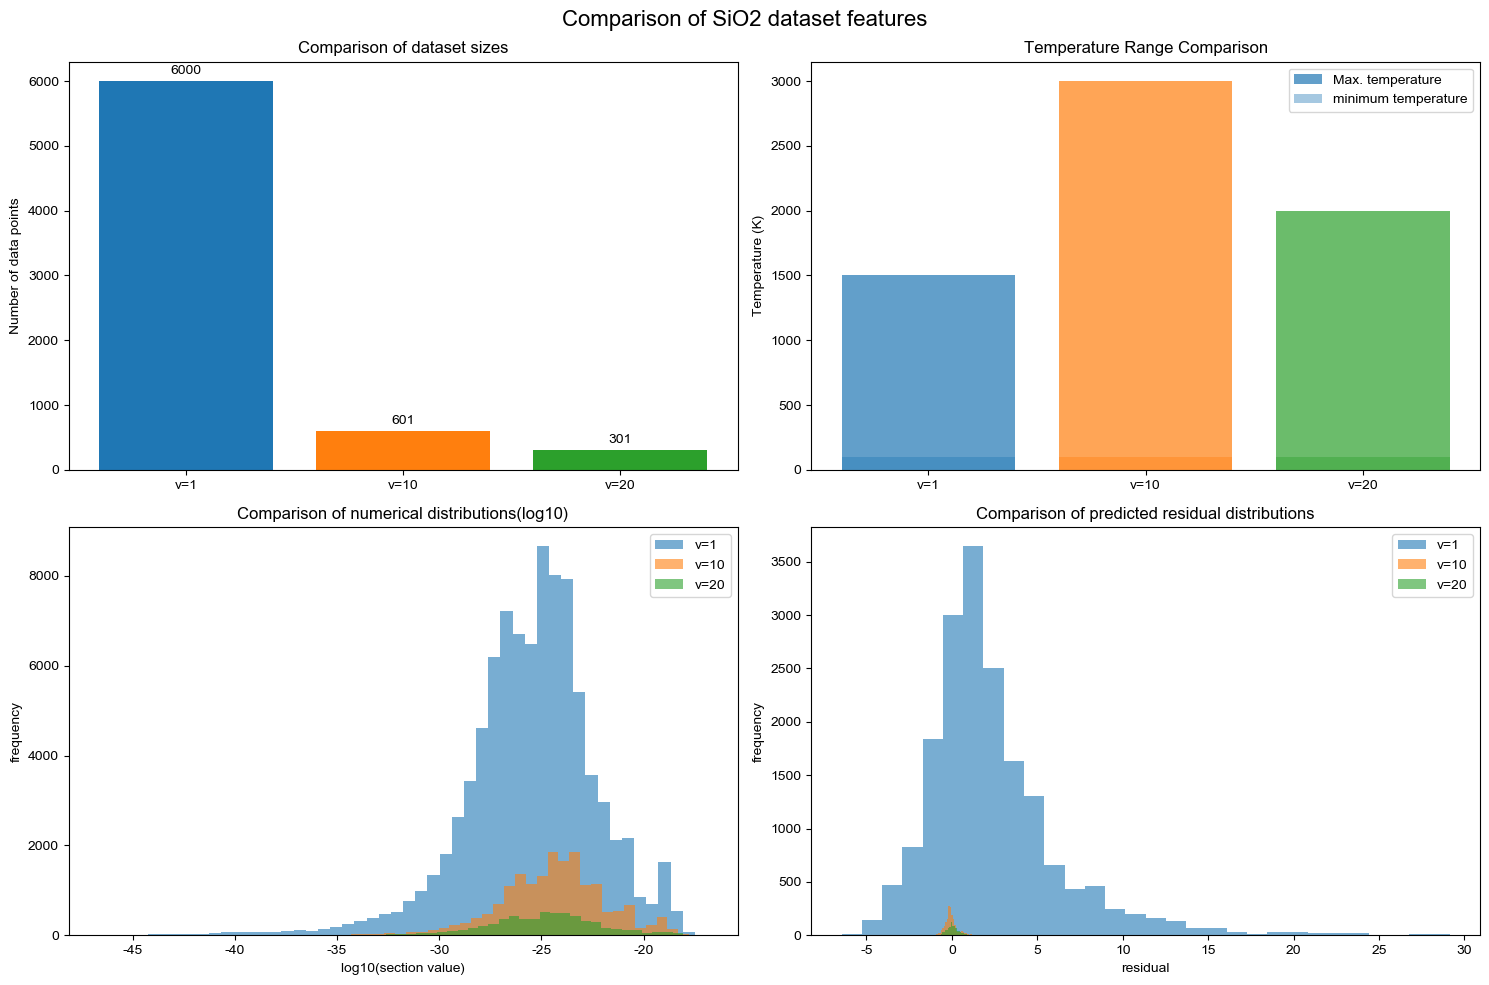


Save results
  ✓ Save Excel results file: sio2_comparison_results.xlsx

Analysis completed！
Documents generated:
  - sio2_comparison_results.png: Comparison chart of forecast results
  - sio2_dataset_comparison.png: Comparison chart of dataset features
  - sio2_comparison_results.xlsx: Detailed results Excel file

suggestion:
  - best model: v=10 (R² = 0.5222)
  - View the generated charts to understand the dataset differences
  - Check Excel file for detailed numerical results


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gmean
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

# Setting Chinese fonts
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def make_poly_mlp(model, degree=2):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        model
    )


class SiO2DataAnalyzer:
    def __init__(self):
        self.datasets = {}
        self.processed_data = {}
        self.models = {}
        self.results = {}
        
    def load_data(self):
        """Load three SiO2 datasets"""
        try:
            self.datasets['v=1'] = pd.read_excel('sio2_v=1.xlsm')
            self.datasets['v=10'] = pd.read_excel('sio2_v=10.xlsm')
            self.datasets['v=20'] = pd.read_excel('sio2_v=20.xlsm')
            print("✓ Successfully loaded all SiO2 datasets")
        except Exception as e:
            print(f"❌ Data loading failure: {e}")
            return False
        return True
    
    def basic_info_comparison(self):
        """Comparison of basic information"""
        print("\n" + "="*60)
        print("SiO2Comparison of basic information of data sets")
        print("="*60)
        
        for name, df in self.datasets.items():
            print(f"\n{name} data set:")
            print(f"  - data shape: {df.shape}")
            print(f"  - Wave number range: {df['wavenumber'].min():.0f} - {df['wavenumber'].max():.0f} cm⁻¹")
            print(f"  - temperature column: {len([col for col in df.columns if col.startswith('t=')])}")            
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            if temp_cols:
                temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                print(f"  - Temperature range: {min(temps)} - {max(temps)} K")
            
            # data statistics
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 1:
                data_values = df[numeric_cols[1:]].values.flatten()
                data_values = data_values[~np.isnan(data_values)]
                if len(data_values) > 0:
                    print(f"  - Numerical range: {data_values.min():.2e} - {data_values.max():.2e}")
                    print(f"  - average value: {data_values.mean():.2e}")
    
    def preprocess_data(self):
        """Data pre-processing and standardisation"""
        print("\n" + "="*60)
        print("Data preprocessing")
        print("="*60)
        
        for name, df in self.datasets.items():
            print(f"\ndeal with {name} data set...")
            
            # Get temperature column
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            
            # Separating training and test data
            test_cols = ['t=1300k', 't=1400k', 't=1500k']
            available_test_cols = [col for col in test_cols if col in temp_cols]
            train_cols = [col for col in temp_cols if col not in test_cols]
            
            if not train_cols:
                print(f"  ❌ {name}: No training data columns found")
                continue
                
            # Data standardisation
            train_data = df[train_cols].copy()
            row_means = train_data.mean(axis=1)
            row_stds = train_data.std(axis=1)
            
            #Avoid dividing by zero
            row_stds = row_stds.replace(0, 1e-10)
            
            # Standardised training data
            train_scaled = train_data.subtract(row_means, axis=0).divide(row_stds, axis=0)
            
            # Processing of test data
            test_data = None
            if available_test_cols:
                test_data = df[available_test_cols].copy()
                test_scaled = test_data.subtract(row_means, axis=0).divide(row_stds, axis=0)
            
            # Convert to long format
            train_df = pd.concat([df[['wavenumber']], train_scaled], axis=1)
            train_long = pd.melt(
                train_df,
                id_vars='wavenumber',
                value_vars=train_cols,
                var_name='temperature',
                value_name='cross_section'
            )
            
            # Clear temperature columns
            train_long['temperature'] = train_long['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).str.replace('K', '', regex=False)
            train_long['temperature'] = train_long['temperature'].astype(int)
            
            processed_item = {
                'train_long': train_long,
                'row_means': row_means,
                'row_stds': row_stds,
                'original_df': df
            }
            
            if test_data is not None:
                test_df = pd.concat([df[['wavenumber']], test_scaled], axis=1)
                test_long = pd.melt(
                    test_df,
                    id_vars='wavenumber',
                    value_vars=available_test_cols,
                    var_name='temperature',
                    value_name='cross_section'
                )
                test_long['temperature'] = test_long['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)
                processed_item['test_long'] = test_long
            
            self.processed_data[name] = processed_item
            print(f"  ✓ {name}: Training data {len(train_long)} 行")
            if test_data is not None:
                print(f"    Test data {len(test_long)} 行")
    
    def train_models(self):
        """Training Machine Learning Models"""
        print("\n" + "="*60)
        print("model training")
        print("="*60)
        
        degree = 6
        alpha = 1.0
        
        for name, data in self.processed_data.items():
            print(f"\ntrain {name} modelling...")
            
            train_long = data['train_long']
            X_train = train_long[['wavenumber', 'temperature']]
            y_train = train_long['cross_section']
            
           
            model = make_poly_mlp(
                    MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000, random_state=1),
                    degree=2
                )
          
            model.fit(X_train, y_train)
            self.models[name] = model
            
           
            if 'test_long' in data:
                test_long = data['test_long']
                X_test = test_long[['wavenumber', 'temperature']]
                y_test = test_long['cross_section']
                y_pred = model.predict(X_test)
                
           
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
                gme = gmean(np.abs(y_test - y_pred) + 1e-8)
                
                self.results[name] = {
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'mape': mape,
                    'gme': gme,
                    'y_test': y_test,
                    'y_pred': y_pred
                }
                
                print(f"  ✓ {name} Model performance:")
                print(f"    MSE: {mse:.4e}")
                print(f"    RMSE: {rmse:.4e}")
                print(f"    MAE: {mae:.4e}")
                print(f"    R²: {r2:.4f}")
                print(f"    MAPE: {mape:.2f}%")
                print(f"    GME: {gme:.4e}")
            else:
                print(f"  ✓ {name} Model training complete (no test data)）")
    
    def create_visualizations(self):
        """Creating visualisation charts"""
        print("\n" + "="*60)
        print("Generate visualisation charts")
        print("="*60)
        
        # 1. Comparison of scatterplots of forecast results
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('SiO2Comparison of data set prediction results', fontsize=16, fontweight='bold')
        
        plot_idx = 0
        for name, result in self.results.items():
            if plot_idx < 3:
                row, col = plot_idx // 2, plot_idx % 2
                ax = axes[row, col]
                
                y_test = result['y_test']
                y_pred = result['y_pred']
                
                ax.scatter(y_test, y_pred, alpha=0.6, s=20)
                ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y=x')
                ax.set_xlabel('real value')
                ax.set_ylabel('prediction value')
                ax.set_title(f'{name} (R² = {result["r2"]:.4f})')
                ax.legend()
                ax.grid(True, alpha=0.3)
                plot_idx += 1
        
        # Comparison of performance indicators
        if len(self.results) > 1:
            ax = axes[1, 1]
            metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']
            x_pos = np.arange(len(metrics))
            width = 0.25
            
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            for i, (name, result) in enumerate(self.results.items()):
                values = [result['mse'], result['rmse'], result['mae'], result['mape']]
                ax.bar(x_pos + i*width, values, width, label=name, color=colors[i % len(colors)])
            
            ax.set_xlabel('Assessment of indicators')
            ax.set_ylabel('numerical value')
            ax.set_title('Comparison of model performance metrics')
            ax.set_xticks(x_pos + width)
            ax.set_xticklabels(metrics)
            ax.legend()
            ax.set_yscale('log')
        
        plt.tight_layout()
        plt.savefig('sio2_comparison_results.png', dpi=300, bbox_inches='tight')
        print("  ✓ Save the comparison chart of prediction results: sio2_comparison_results.png")
        
        # 2. Comparison of data set size and distribution
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Comparison of SiO2 dataset features', fontsize=16, fontweight='bold')
        
        # Comparison of dataset sizes
        ax1 = axes[0, 0]
        names = list(self.datasets.keys())
        sizes = [df.shape[0] for df in self.datasets.values()]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        bars = ax1.bar(names, sizes, color=colors)
        ax1.set_title('Comparison of dataset sizes')
        ax1.set_ylabel('Number of data points')
        for bar, size in zip(bars, sizes):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.01, 
                    str(size), ha='center', va='bottom')
        
        # Temperature Range Comparison
        ax2 = axes[0, 1]
        temp_ranges = []
        for name, df in self.datasets.items():
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            if temp_cols:
                temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                temp_ranges.append((min(temps), max(temps)))
            else:
                temp_ranges.append((0, 0))
        
        x_pos = np.arange(len(names))
        min_temps = [r[0] for r in temp_ranges]
        max_temps = [r[1] for r in temp_ranges]
        
        ax2.bar(x_pos, max_temps, color=colors, alpha=0.7, label='Max. temperature')
        ax2.bar(x_pos, min_temps, color=colors, alpha=0.4, label='minimum temperature')
        ax2.set_title('Temperature Range Comparison')
        ax2.set_ylabel('Temperature (K)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(names)
        ax2.legend()
        
        # Comparison of numerical distributions
        ax3 = axes[1, 0]
        for i, (name, df) in enumerate(self.datasets.items()):
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 1:
                data_values = df[numeric_cols[1:]].values.flatten()
                data_values = data_values[~np.isnan(data_values)]
                if len(data_values) > 0:
                    ax3.hist(np.log10(data_values + 1e-50), bins=50, alpha=0.6, 
                            label=name, color=colors[i])
        ax3.set_title('Comparison of numerical distributions(log10)')
        ax3.set_xlabel('log10(section value)')
        ax3.set_ylabel('frequency')
        ax3.legend()
        
        # Comparison of residual distributions
        ax4 = axes[1, 1]
        for i, (name, result) in enumerate(self.results.items()):
            residuals = result['y_test'] - result['y_pred']
            ax4.hist(residuals, bins=30, alpha=0.6, label=name, color=colors[i])
        ax4.set_title('Comparison of predicted residual distributions')
        ax4.set_xlabel('residual')
        ax4.set_ylabel('frequency')
        ax4.legend()
        
        plt.tight_layout()
        plt.savefig('sio2_dataset_comparison.png', dpi=300, bbox_inches='tight')
        print("  ✓ Save the dataset feature comparison chart: sio2_dataset_comparison.png")
        
        plt.show()
    
    def save_results_to_excel(self):
        """Save results to Excel file"""
        print("\n" + "="*60)
        print("Save results")
        print("="*60)
        
        with pd.ExcelWriter('sio2_comparison_results.xlsx', engine='openpyxl') as writer:
            # Summary of basic information
            summary_data = []
            for name, df in self.datasets.items():
                temp_cols = [col for col in df.columns if col.startswith('t=')]
                temps = []
                if temp_cols:
                    temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                data_values = df[numeric_cols[1:]].values.flatten() if len(numeric_cols) > 1 else []
                data_values = data_values[~np.isnan(data_values)] if len(data_values) > 0 else []
                
                summary_data.append({
                    'data set': name,
                    'data point': df.shape[0],
                    'characteristic number (math.)': df.shape[1],
                    'Minimum temperature (K)': min(temps) if temps else 'N/A',
                    'Max. temperature (K)': max(temps) if temps else 'N/A',
                    'minimum value': f"{data_values.min():.2e}" if len(data_values) > 0 else 'N/A',
                    'maximum values': f"{data_values.max():.2e}" if len(data_values) > 0 else 'N/A',
                    'average value': f"{data_values.mean():.2e}" if len(data_values) > 0 else 'N/A'
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='Overview of data sets', index=False)
            
            # Model Performance Comparison
            if self.results:
                performance_data = []
                for name, result in self.results.items():
                    performance_data.append({
                        'data set': name,
                        'MSE': f"{result['mse']:.4e}",
                        'RMSE': f"{result['rmse']:.4e}",
                        'MAE': f"{result['mae']:.4e}",
                        'R²': f"{result['r2']:.4f}",
                        'MAPE(%)': f"{result['mape']:.2f}",
                        'GME': f"{result['gme']:.4e}"
                    })
                
                performance_df = pd.DataFrame(performance_data)
                performance_df.to_excel(writer, sheet_name='Model Performance Comparison', index=False)
            
            # Preservation of raw data
            for name, df in self.datasets.items():
                sheet_name = f'raw data_{name.replace("=", "_")}'
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print("  ✓ Save Excel results file: sio2_comparison_results.xlsx")
    
    def run_complete_analysis(self):
        """Run a complete comparative analysis"""
        print("Comparative analysis of SiO2 datasets started...")
        print("="*60)
        
        if not self.load_data():
            return
        
        self.basic_info_comparison()
        self.preprocess_data()
        self.train_models()
        self.create_visualizations()
        self.save_results_to_excel()
        
        print("\n" + "="*60)
        print("Analysis completed！")
        print("="*60)
        print("Documents generated:")
        print("  - sio2_comparison_results.png: Comparison chart of forecast results")
        print("  - sio2_dataset_comparison.png: Comparison chart of dataset features")
        print("  - sio2_comparison_results.xlsx: Detailed results Excel file")
        print("\nsuggestion:")
        if self.results:
            best_model = max(self.results.items(), key=lambda x: x[1]['r2'])
            print(f"  - best model: {best_model[0]} (R² = {best_model[1]['r2']:.4f})")
        print("  - View the generated charts to understand the dataset differences")
        print("  - Check Excel file for detailed numerical results")

if __name__ == "__main__":
    analyzer = SiO2DataAnalyzer()
    analyzer.run_complete_analysis()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.419e+03, tolerance: 6.600e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.932e+03, tolerance: 1.563e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.011e+02, toler

     Dataset        MSE      RMSE       MAE            R2
0   sio2 v=1  24.804418  4.980403  4.746599 -1.070703e+40
1  sio2 v=10   0.080017  0.282873  0.268168 -3.863011e+37
2  sio2 v=20   0.096241  0.310228  0.269208 -7.092102e+37


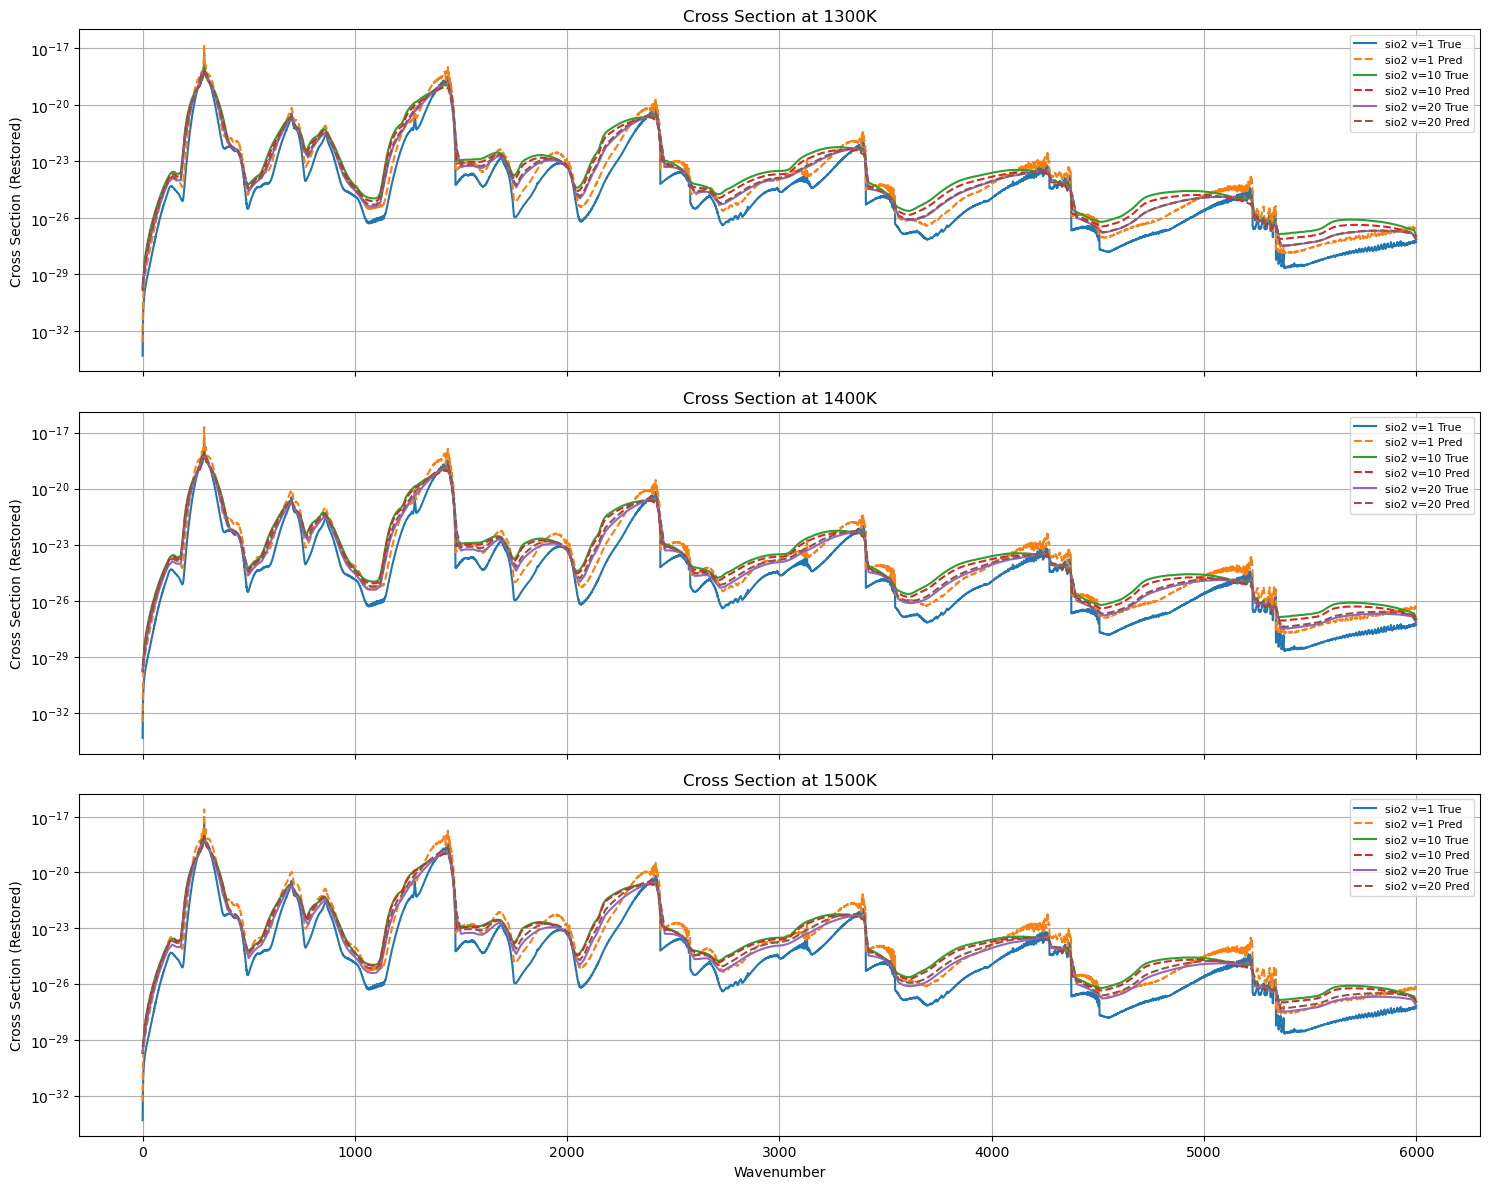

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== Data set path ==========
datasets = {
    'sio2 v=1': 'sio2_v=1.xlsm',
    'sio2 v=10': 'sio2_v=10.xlsm',
    'sio2 v=20': 'sio2_v=20.xlsm'
}

# ========== Defining function: normalisation + training + prediction + back-normalisation==========
def process_dataset(name, file):
    # retrieve data
    df = pd.read_excel(file)
    df = df.rename(columns={'number': 'wavenumber'})
    
    # Divide training/testing (1300, 1400, 1500K for testing)
    columns_to_exclude = ['t=1300k', 't=1400k', 't=1500k']
    columns_to_normalize = [col for col in df.columns if col.startswith('t=') and col not in columns_to_exclude]

    # standardisation by bank
    data_to_normalize = df[columns_to_normalize].copy()
    row_means = data_to_normalize.mean(axis=1)
    row_stds = data_to_normalize.std(axis=1)
    df_scaled = (data_to_normalize.subtract(row_means, axis=0)).divide(row_stds, axis=0)

    # Save statistics
    df_stats = pd.DataFrame({
        'wavenumber': df['wavenumber'],
        'row_mean': row_means,
        'row_std': row_stds
    }).set_index('wavenumber')

    # Training data after splicing normalisation
    train_df = pd.concat([df[['wavenumber']], df_scaled], axis=1)

    #  long chart
    long_df = pd.melt(
        train_df,
        id_vars='wavenumber',
        value_vars=[col for col in train_df.columns if col.startswith('t=')],
        var_name='temperature',
        value_name='cross_section'
    )
    long_df['temperature'] = long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    # Training/test set division
    test_df = df[['wavenumber'] + columns_to_exclude].rename(columns={'number': 'wavenumber'})
    test_long_df = pd.melt(
        test_df,
        id_vars='wavenumber',
        value_vars=columns_to_exclude,
        var_name='temperature',
        value_name='cross_section'
    )
    test_long_df['temperature'] = test_long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    X_train, y_train = long_df[['wavenumber', 'temperature']], long_df['cross_section']
    X_test, y_test = test_long_df[['wavenumber', 'temperature']], test_long_df['cross_section']

    # modelling
    model = make_pipeline(
        PolynomialFeatures(degree=6, include_bias=False),
        Lasso(alpha=1.0, max_iter=5000)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save predictions
    test_long_df['predicted'] = y_pred

    # inverse normalisation
    cross_section_restored = []
    predicted_restored = []
    for idx, row in test_long_df.iterrows():
        wnum = row['wavenumber']
        mean = df_stats.loc[wnum, 'row_mean']
        std = df_stats.loc[wnum, 'row_std']
        cs_restored = row['cross_section'] * std + mean
        pred_restored = row['predicted'] * std + mean
        cross_section_restored.append(cs_restored)
        predicted_restored.append(pred_restored)

    test_long_df['cross_section_restored'] = cross_section_restored
    test_long_df['predicted_restored'] = predicted_restored

    # Calculation of error indicators
    mse = mean_squared_error(test_long_df['cross_section'], test_long_df['predicted'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_long_df['cross_section'], test_long_df['predicted'])
    r2 = r2_score(test_long_df['cross_section'], test_long_df['predicted'])

    metrics = {'Dataset': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return test_long_df, metrics

# ========== Loop through all data sets==========
results = {}
metrics_list = []
for name, file in datasets.items():
    df_result, metric = process_dataset(name, file)
    results[name] = df_result
    metrics_list.append(metric)

# Printing Error Indicator
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# ========== draw a comparison chart==========
temps = [1300, 1400, 1500]
fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

for i, temp in enumerate(temps):
    ax = axs[i]
    for name, df in results.items():
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label=f'{name} True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label=f'{name} Pred')
    ax.set_title(f'Cross Section at {temp}K')
    ax.set_ylabel('Cross Section (Restored)')
    ax.legend(fontsize=8)
    ax.grid(True)
    ax.set_yscale('log')

axs[-1].set_xlabel('Wavenumber')
plt.tight_layout()
plt.show()

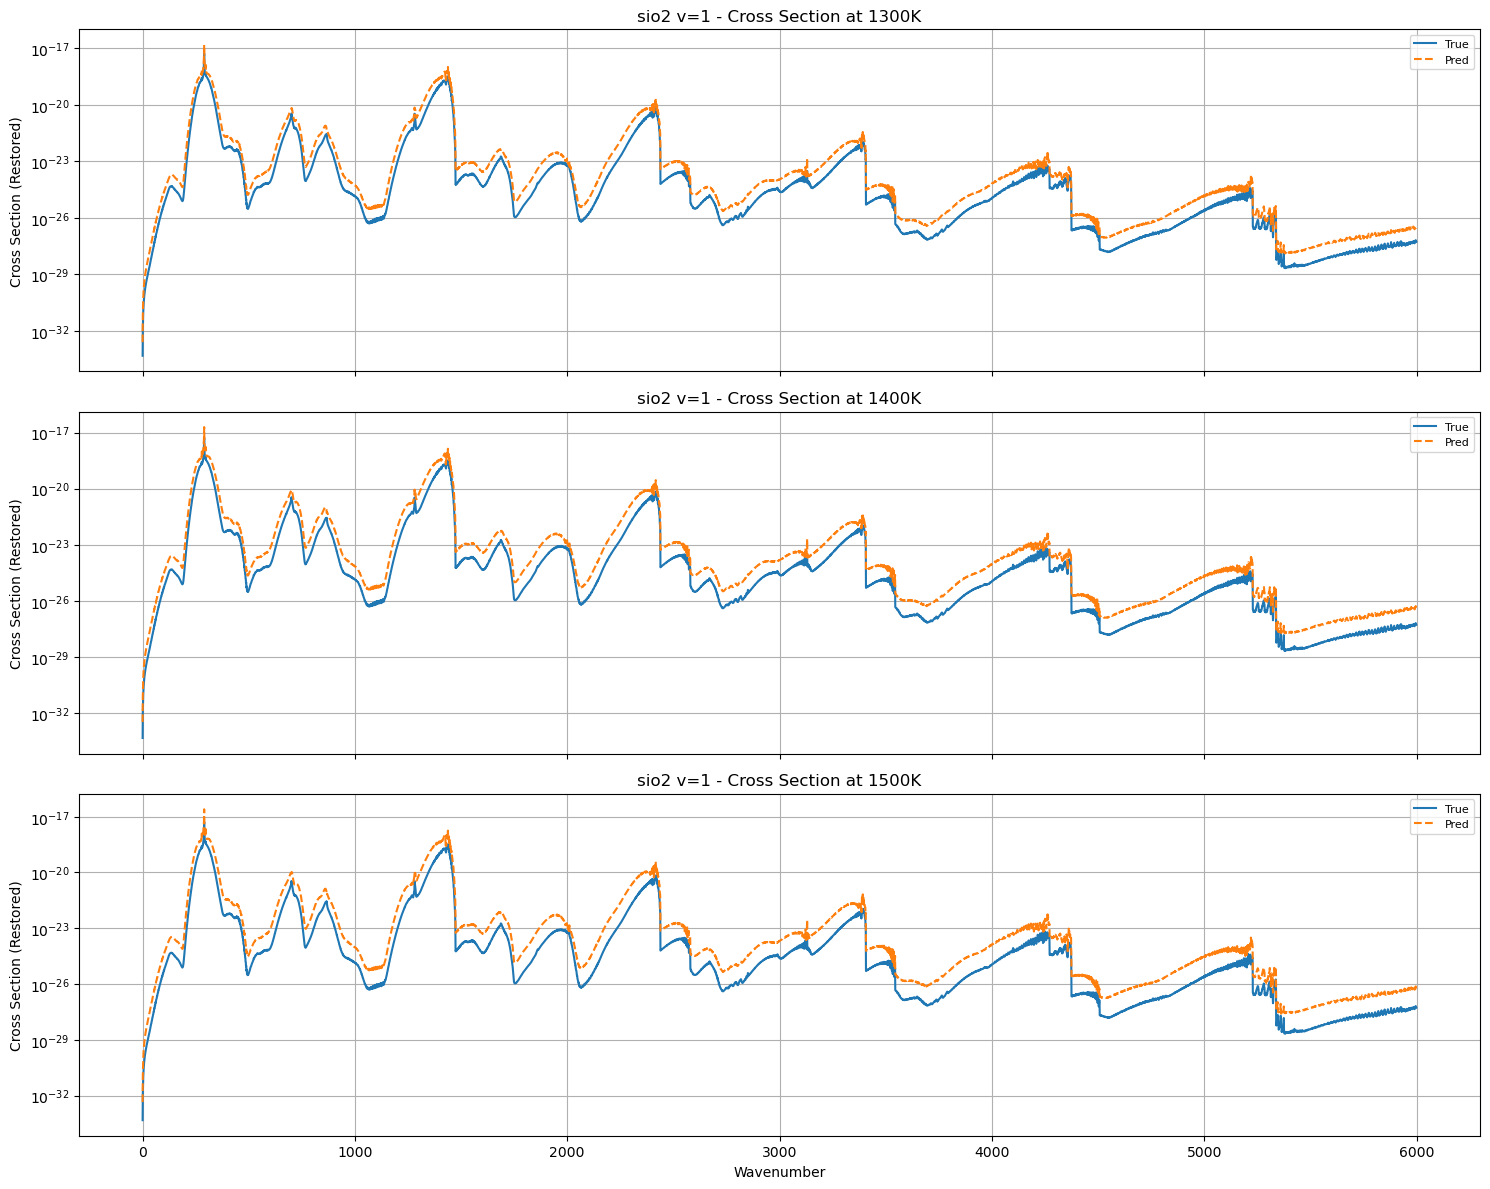

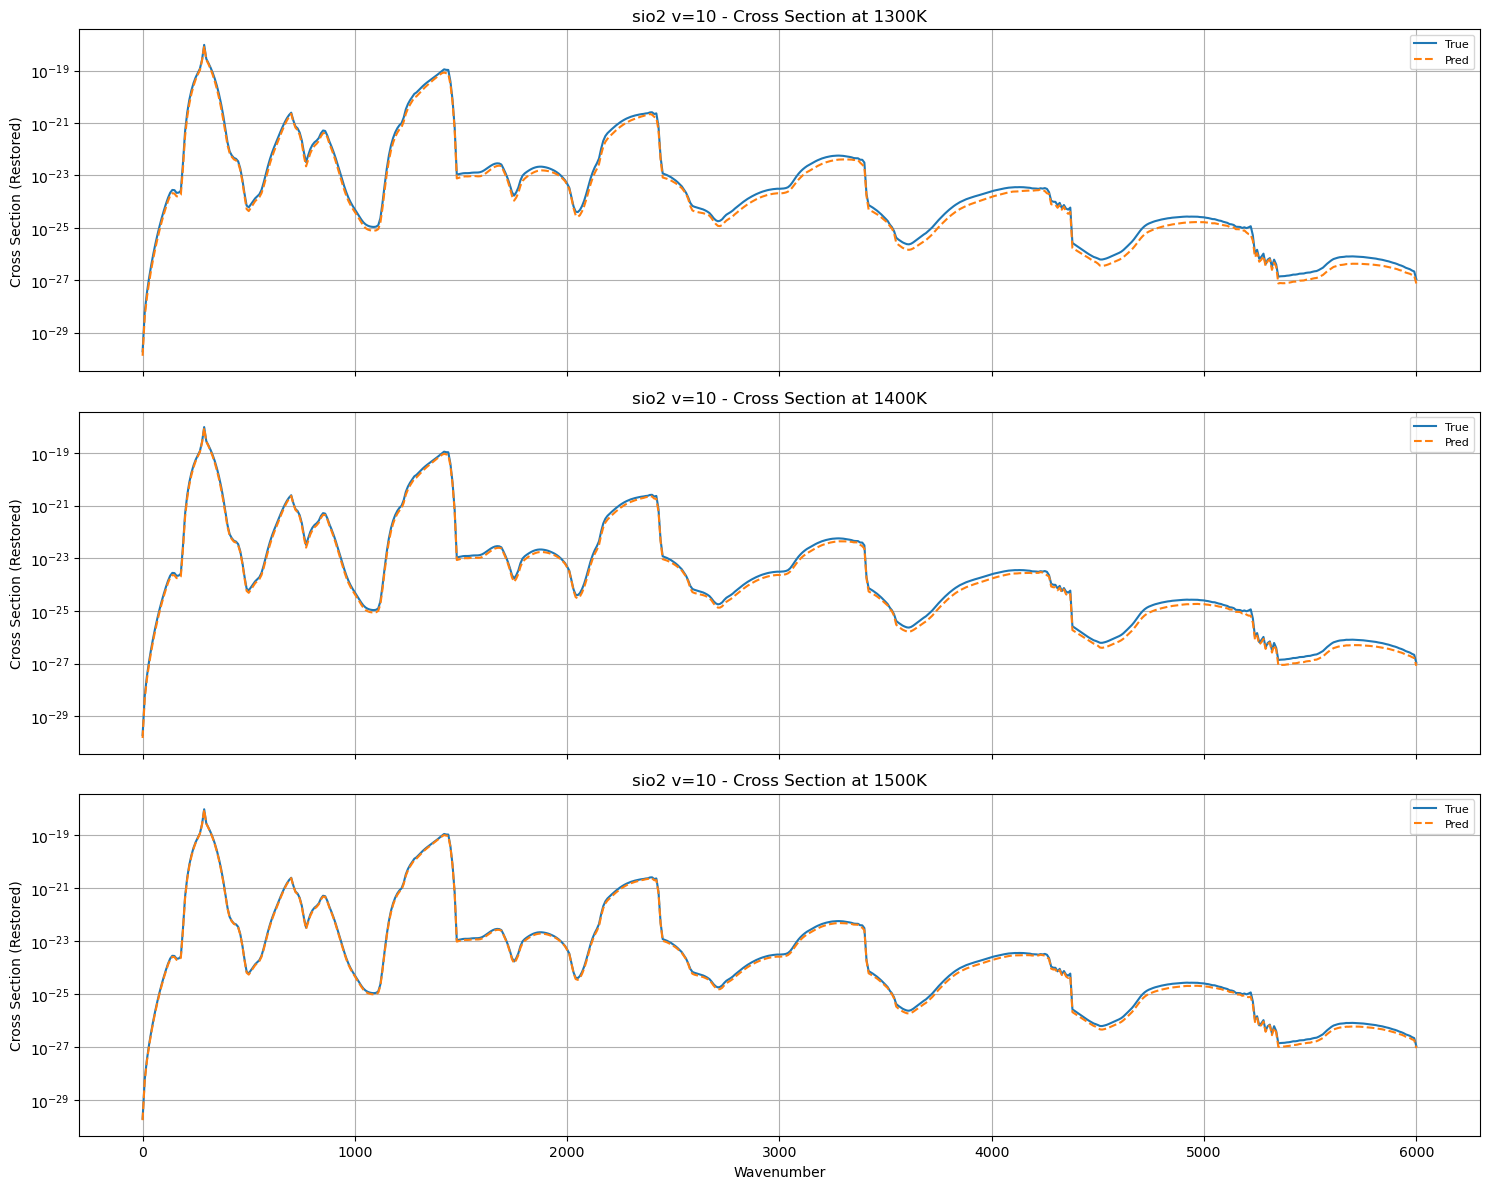

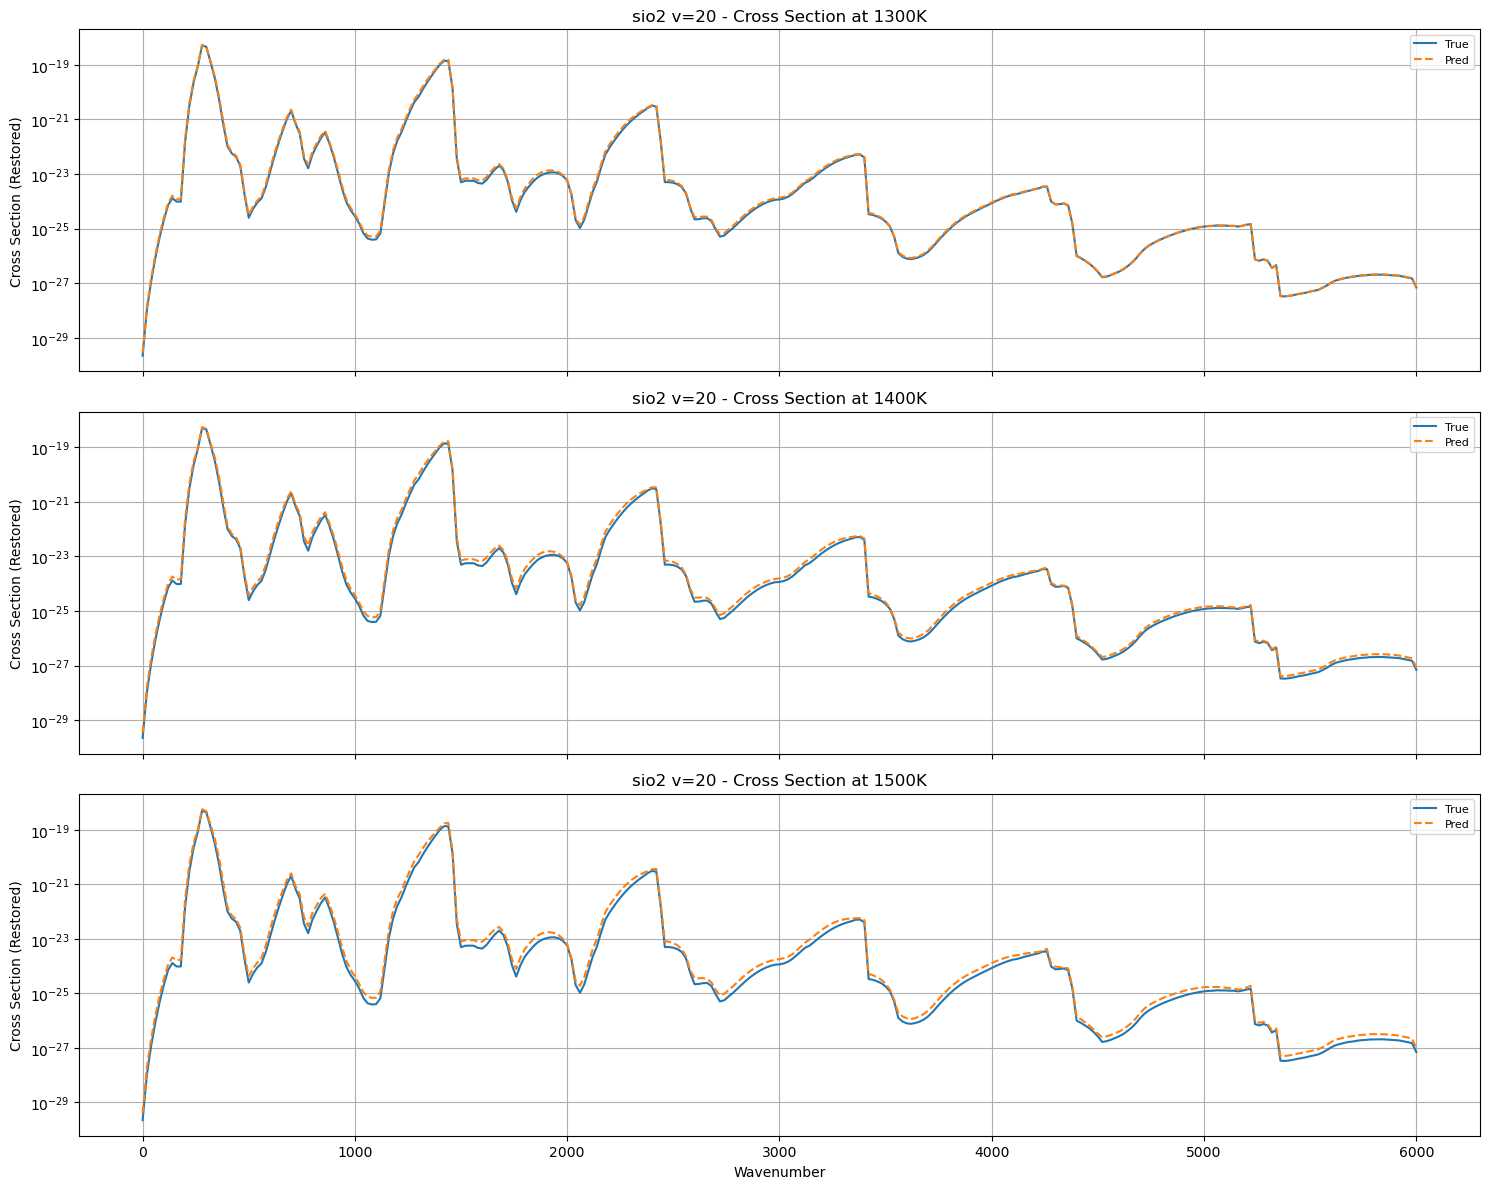

In [2]:
# ========== Draw a separate graph for each dataset==========
temps = [1300, 1400, 1500]

for name, df in results.items():
    fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

    for i, temp in enumerate(temps):
        ax = axs[i]
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label='True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label='Pred')
        ax.set_title(f'{name} - Cross Section at {temp}K')
        ax.set_ylabel('Cross Section (Restored)')
        ax.legend(fontsize=8)
        ax.grid(True)
        ax.set_yscale('log')

    axs[-1].set_xlabel('Wavenumber')
    plt.tight_layout()
    plt.show()